# ArchPy2Modflow: Unstructured Grids

## Create ArchPy model

In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt
import geone
import geone.covModel as gcm
import geone.imgplot3d as imgplt3
import pyvista as pv
import sys
import os

sys.path.append("../../")
#my modules
from ArchPy.base import *
from ArchPy.tpgs import *

%load_ext autoreload
%autoreload 2

In [2]:
pv.set_jupyter_backend('static')

In [3]:
#grid
sx = 1.5
sy = 1.5
sz = .15
x0 = 100
y0 = 100
z0 = -15
nx = 140
ny = 70
nz = 70
x1 = x0 + nx*sx
y1 = y0 + ny*sy
z1 = z0 + nz

dimensions = (nx, ny, nz)
spacing = (sx, sy, sz)
origin = (x0, y0, z0)  

In [4]:
## create pile

P1 = Pile(name = "P1",seed=1)

#units covmodel
covmodelD = gcm.CovModel2D(elem=[('cubic', {'w':0.6, 'r':[30,30]})])
covmodelD1 = gcm.CovModel2D(elem=[('cubic', {'w':0.2, 'r':[30,30]})])
covmodelC = gcm.CovModel2D(elem=[('cubic', {'w':0.2, 'r':[40,40]})])
covmodelB = gcm.CovModel2D(elem=[('cubic', {'w':0.6, 'r':[30,30]})])
covmodel_er = gcm.CovModel2D(elem=[('spherical', {'w':1, 'r':[50,50]})])

## facies covmodel
covmodel_SIS_C = gcm.CovModel3D(elem=[("exponential", {"w":.21,"r":[50, 50, 10]})], alpha=0, name="vario_SIS") # input variogram
covmodel_SIS_B1 = gcm.CovModel3D(elem=[("exponential", {"w":.16,"r":[50, 50, 2]})], alpha=0, name="vario_SIS") # input variogram
covmodel_SIS_B2 = gcm.CovModel3D(elem=[("exponential", {"w":.24,"r":[100, 100, 3]})], alpha=0, name="vario_SIS") # input variogram
covmodel_SIS_B3 = gcm.CovModel3D(elem=[("exponential", {"w":.19,"r":[50, 50, 2]})], alpha=0, name="vario_SIS") # input variogram
covmodel_SIS_B4 = gcm.CovModel3D(elem=[("exponential", {"w":.13,"r":[100, 100, 4]})], alpha=0, name="vario_SIS") # input variogram

lst_covmodelC=[covmodel_SIS_C] # list of covmodels to pass at the function
lst_covmodelB=[covmodel_SIS_B1, covmodel_SIS_B2, covmodel_SIS_B3, covmodel_SIS_B4] # list of covmodels to pass


#create Lithologies 
dic_s_D = {"int_method" : "grf_ineq","covmodel" : covmodelD}
dic_f_D = {"f_method":"homogenous"}
D = Unit(name="D",order=1,ID = 1,color="gold",contact="onlap",surface=Surface(contact="onlap",dic_surf=dic_s_D)
         ,dic_facies=dic_f_D)

dic_s_C = {"int_method" : "grf_ineq","covmodel" : covmodelC, "mean":-6.5}
dic_f_C = {"f_method" : "SIS","neig" : 10, "f_covmodel":lst_covmodelC, "probability":[0.3, 0.7]}
C = Unit(name="C", order=2, ID = 2, color="blue", contact="onlap", dic_facies=dic_f_C, surface=Surface(dic_surf=dic_s_C, contact="onlap"))

dic_s_B = {"int_method" : "grf_ineq","covmodel" : covmodelB, "mean":-8.5}
dic_f_B = {"f_method":"SIS", "neig" : 10, "f_covmodel":lst_covmodelB, "probability":[0.2, 0.4, 0.25, 0.15]}
B = Unit(name="B",order=3,ID = 3,color="purple",contact="onlap",dic_facies=dic_f_B,surface=Surface(contact="onlap",dic_surf=dic_s_B))

dic_s_A = {"int_method":"grf_ineq","covmodel": covmodelB, "mean":-11}
dic_f_A = {"f_method":"homogenous"}
A = Unit(name="A",order=5,ID = 5,color="red",contact="onlap",dic_facies=dic_f_A,surface=Surface(dic_surf = dic_s_A,contact="onlap"))

#Master pile
P1.add_unit([D,C,B,A])

Unit D: Surface added for interpolation
Unit C: Surface added for interpolation
Unit B: Surface added for interpolation
Unit A: Surface added for interpolation
Stratigraphic unit D added ✅
Stratigraphic unit C added ✅
Stratigraphic unit B added ✅
Stratigraphic unit A added ✅


In [5]:
# covmodels for the property model
covmodelK = gcm.CovModel3D(elem=[("exponential",{"w":0.3,"r":[30,30,10]})],alpha=-20,name="K_vario")
covmodelK2 = gcm.CovModel3D(elem=[("spherical",{"w":0.1,"r":[20,20, 5]})],alpha=0,name="K_vario_2")

facies_1 = Facies(ID = 1,name="Sand",color="yellow")
facies_2 = Facies(ID = 2,name="Gravel",color="lightgreen")
facies_3 = Facies(ID = 3,name="GM",color="blueviolet")
facies_4 = Facies(ID = 4,name="Clay",color="blue")
facies_5 = Facies(ID = 5,name="SM",color="brown")
facies_6 = Facies(ID = 6,name="Silt",color="goldenrod")
facies_7 = Facies(ID = 7,name="basement",color="red")

A.add_facies([facies_7])
B.add_facies([facies_1, facies_2, facies_3, facies_5])
D.add_facies([facies_1])
C.add_facies([facies_4, facies_6])

# property model
cm_prop1 = gcm.CovModel3D(elem = [("spherical", {"w":0.1, "r":[10,10,10]}),
                                  ("cubic", {"w":0.1, "r":[15,15,15]})])
cm_prop2 = gcm.CovModel3D(elem = [("cubic", {"w":0.2, "r":[25, 25, 5]})])

list_facies = [facies_1, facies_2, facies_3, facies_4, facies_5, facies_6, facies_7]
list_covmodels = [cm_prop2, cm_prop1, cm_prop2, cm_prop1, cm_prop2, cm_prop1, cm_prop2]
means = [-4, -2, -6, -9, -6, -7, -19]
prop_model = ArchPy.base.Prop("K",
                              facies = list_facies,
                              covmodels = list_covmodels,
                                means = means,
                                int_method = "sgs",
                                vmin = -10,
                                vmax = -1
                                )

cm_prop1 = gcm.CovModel3D(elem = [("spherical", {"w":0.005, "r":[10, 10, 10]})])
cm_prop2 = gcm.CovModel3D(elem = [("cubic", {"w":0.005, "r":[25, 25, 25]})])

list_facies = [facies_1, facies_2, facies_3, facies_4, facies_5, facies_6, facies_7]
list_covmodels = [cm_prop2, cm_prop1, cm_prop2, cm_prop1, cm_prop2, cm_prop1, cm_prop1]

Porosity = ArchPy.base.Prop("Porosity",
                            facies = list_facies,
                            covmodels = list_covmodels,
                            means = [0.2, 0.25, 0.15, 0.1, 0.15, 0.2, 0.05],
                            int_method = ["sgs","sgs","sgs","sgs","sgs","sgs","homogenous"],
                            vmin = 0,
                            vmax = 0.4
                            )


Facies basement added to unit A ✅
Facies Sand added to unit B ✅
Facies Gravel added to unit B ✅
Facies GM added to unit B ✅
Facies SM added to unit B ✅
Facies Sand added to unit D ✅
Facies Clay added to unit C ✅
Facies Silt added to unit C ✅


In [6]:
top = np.ones([ny,nx])*-6
bot = np.ones([ny,nx])*z0

In [7]:
T1 = Arch_table(name = "P1",seed=3)
T1.set_Pile_master(P1)
T1.add_grid(dimensions, spacing, origin, top=top,bot=bot, rotation_angle=30)
T1.add_prop([prop_model, Porosity])

Pile sets as Pile master
## Adding Grid ##
## Grid added and is now simulation grid ##
Property K added
Property Porosity added


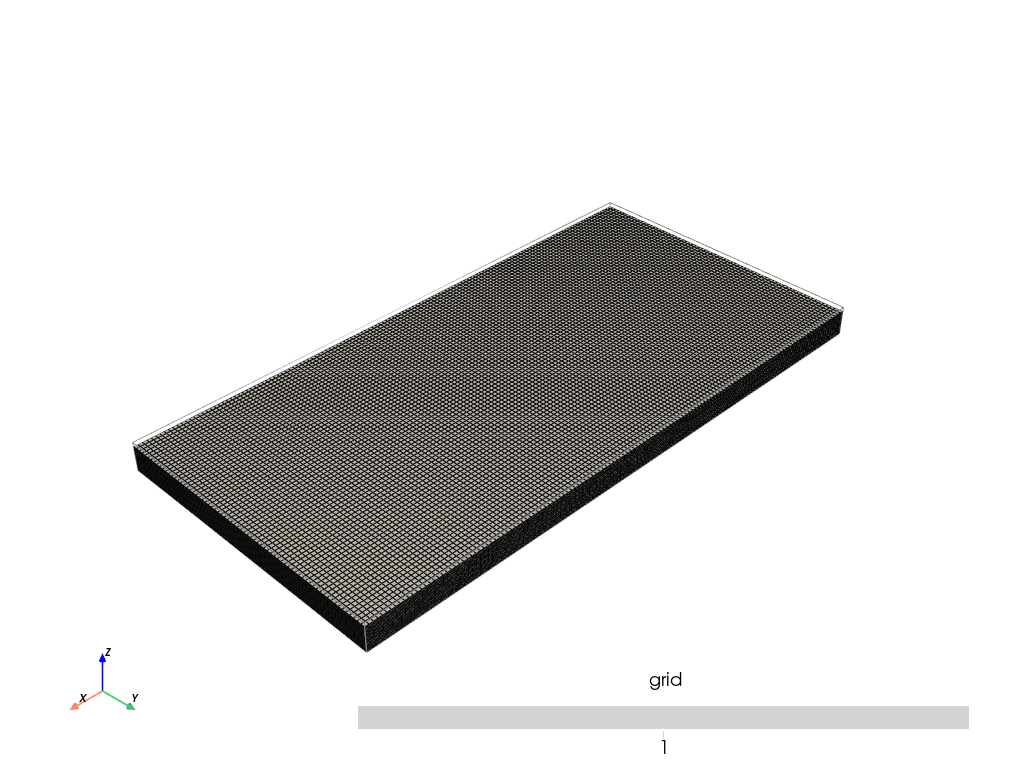

In [8]:
T1.plot_grid()

In [9]:
T1.compute_surf(1)
T1.compute_facies(1)
T1.compute_prop(1)

Boreholes not processed, fully unconditional simulations will be tempted
########## PILE P1 ##########
Pile P1: ordering units
Stratigraphic units have been sorted according to order
Discrepency in the orders for units A and B
Changing orders for that they range from 1 to n

#### COMPUTING SURFACE OF UNIT A
A: time elapsed for computing surface 0.07905435562133789 s

#### COMPUTING SURFACE OF UNIT B
B: time elapsed for computing surface 0.048288822174072266 s

#### COMPUTING SURFACE OF UNIT C
C: time elapsed for computing surface 0.050009965896606445 s

#### COMPUTING SURFACE OF UNIT D
D: time elapsed for computing surface 0.0 s

Time elapsed for getting domains 0.01795029640197754 s


##########################


### 0.21343040466308594: Total time elapsed for computing surfaces ###

### Unit D: facies simulation with homogenous method ####
### Unit D - realization 0 ###
Time elapsed 0.0 s

### Unit C: facies simulation with SIS method ####
### Unit C - realization 0 ###
Only one facies covmodels for multiples facies, adapt sill to right proportions


Time elapsed 1.76 s

### Unit B: facies simulation with SIS method ####
### Unit B - realization 0 ###


Time elapsed 2.18 s

### Unit A: facies simulation with homogenous method ####
### Unit A - realization 0 ###
Time elapsed 0.0 s

### 3.94: Total time elapsed for computing facies ###
### 1 K property models will be modeled ###


### 1 K models done
### 1 Porosity property models will be modeled ###


### 1 Porosity models done


In [10]:
import flopy as fp

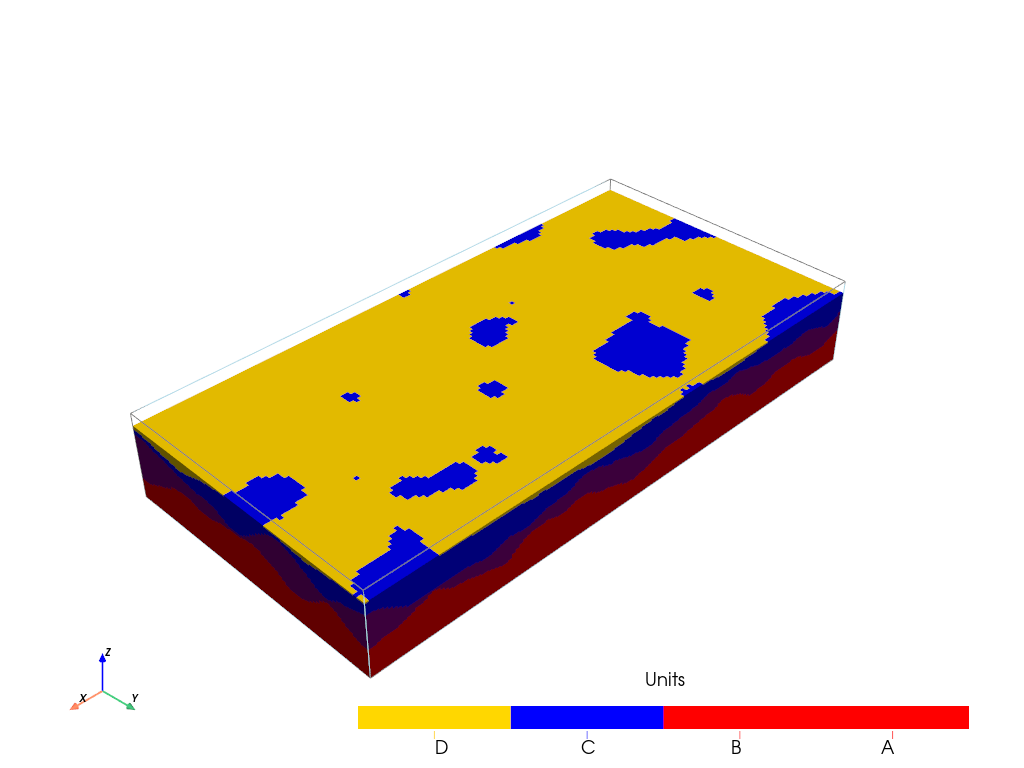

In [11]:
T1.plot_units(v_ex=3)

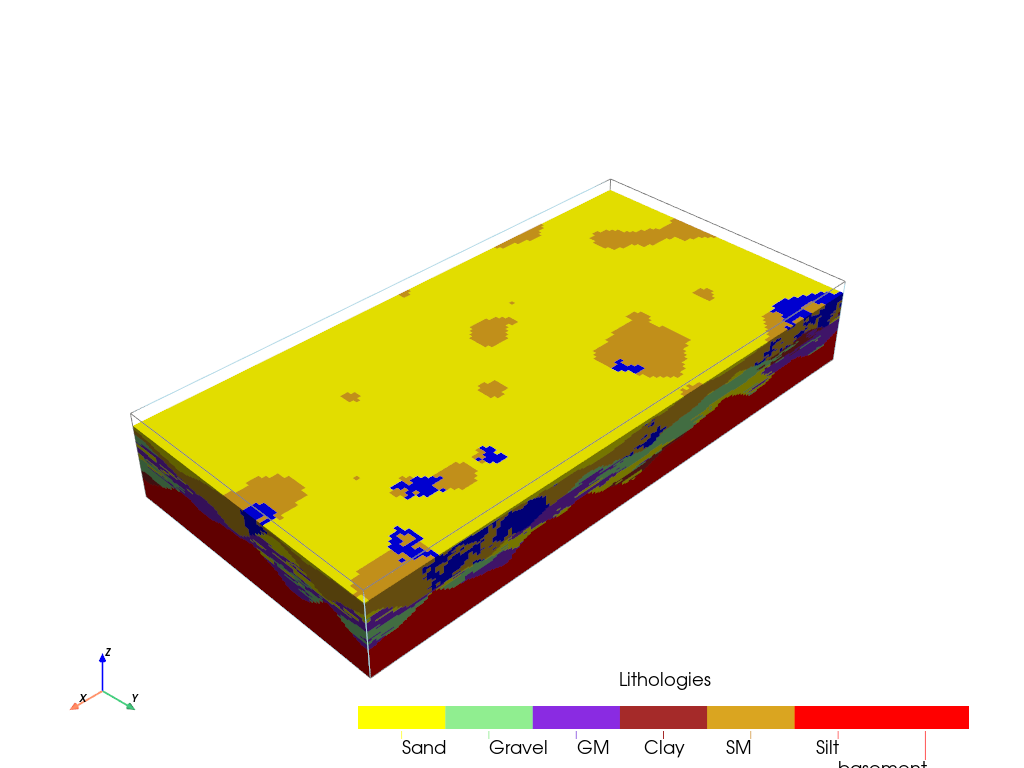

In [12]:
T1.plot_facies(v_ex=3)

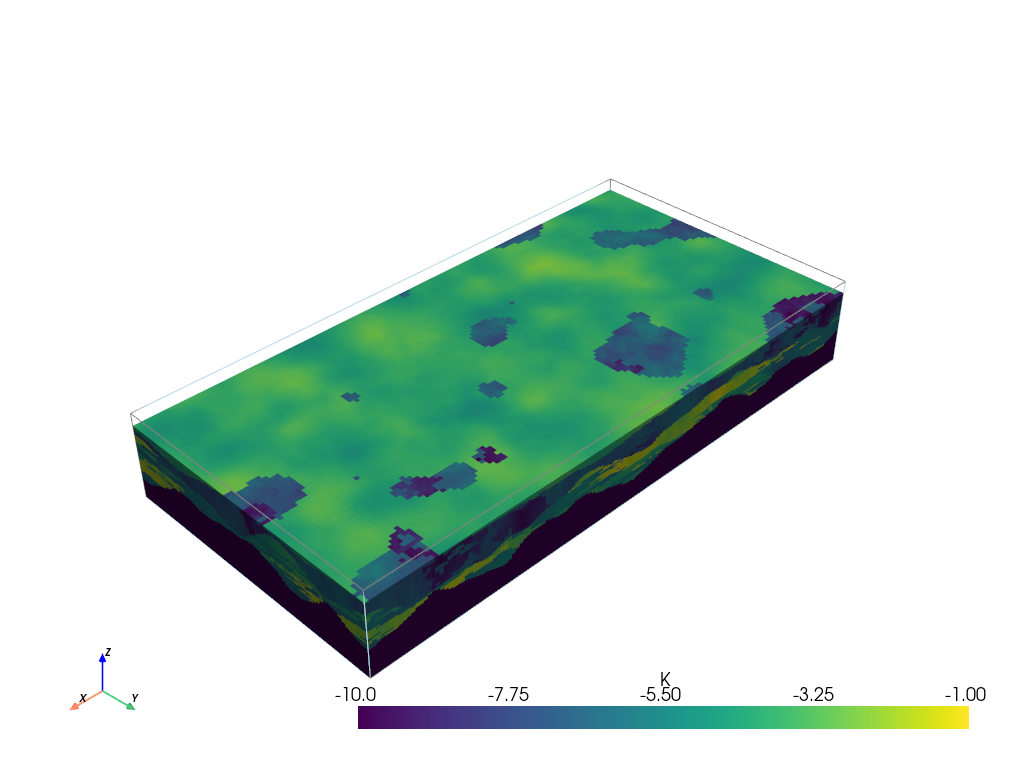

In [13]:
T1.plot_prop("K", v_ex=3)

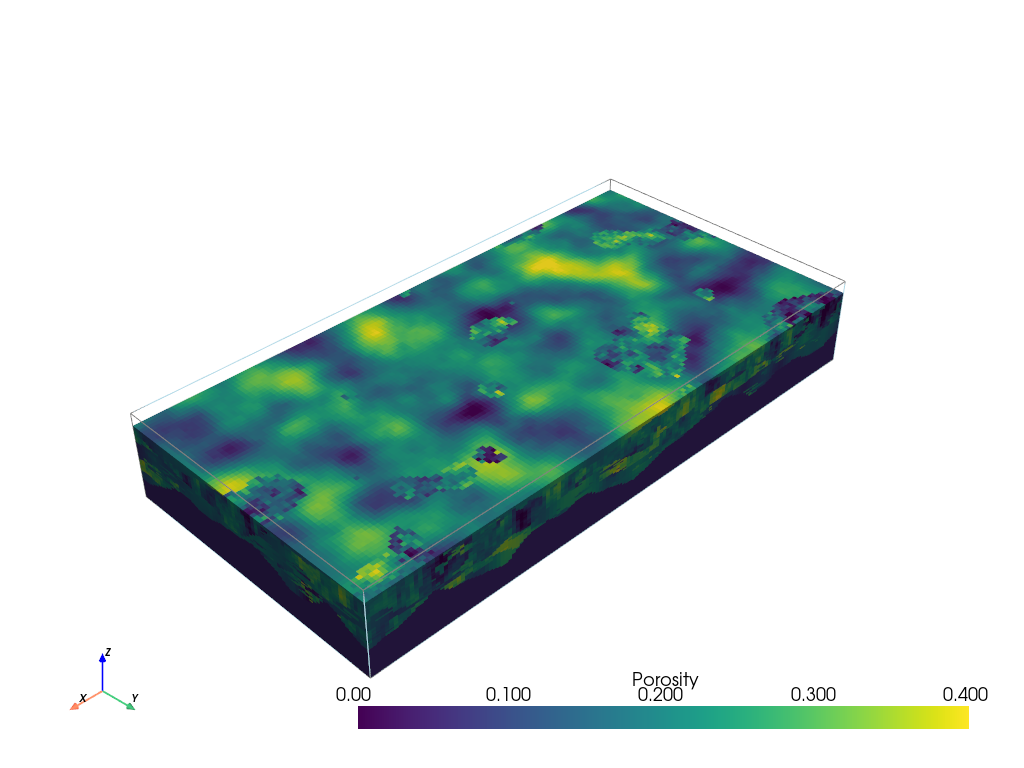

In [14]:
T1.plot_prop("Porosity", v_ex=3)

In [15]:
val = T1.get_prop("K")[0, 0, 0]
im = geone.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=x0, oy=y0, oz=z0, nv=1, val=val)

In [16]:
import ArchPy.ap_mf
from ArchPy.ap_mf import archpy2modflow, array2cellids

## Create a modflow grid 

(can be disv or disu)

In [17]:
import flopy
from flopy.utils.gridgen import Gridgen
from flopy.export.vtk import Vtk

gridgen_path = "../../../../exe/gridgen.exe"

In [18]:
# create a grid  --> we can create a fake modflow model to use the gridgen

# 3D example
# grid dimensions
nlay = 4
nrow = 16
ncol = 24
delr = 8.5
delc = 6.
top = -6
ox = 102
oy = 105
rot_angle = T1.rot_angle

botm = np.linspace(-6.5, -15, nlay)

sim = flopy.mf6.MFSimulation(
    sim_name="asdf", sim_ws="ws", exe_name="mf6")
tdis = flopy.mf6.ModflowTdis(sim, time_units="DAYS", perioddata=[[1.0, 1, 1.0]])
ms = flopy.mf6.ModflowGwf(sim, modelname="asdf", save_flows=True)
dis = flopy.mf6.ModflowGwfdis(
    ms,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    xorigin=0,  # gridgen will be applied on a grid with origin at 0, 0
    yorigin=0,
    angrot=rot_angle,
)

# create Gridgen object
g = Gridgen(ms.modelgrid, model_ws="gridgen_ws", exe_name=gridgen_path)  

polygon = [
    [
        (200, 200),
        (200, 210),
        (140, 180),
        (140, 180),
        (200, 200),
    ]
]
polygon = np.array(polygon)
polygon = polygon - [ox, oy]  # move the polygon to the origin

g.add_refinement_features([polygon], "polygon", 2, range(nlay))
refshp0 = "gridgen_ws/" + "rf0"

In [19]:
g.build(verbose=False)

In [20]:
ms.dis.remove()
disv_gridprops = g.get_gridprops_disv()
disv = flopy.mf6.ModflowGwfdisv(ms, **disv_gridprops, xorigin=ox, yorigin=oy, angrot=0)  # create grid this time with the origin at ox, oy
# disu = flopy.mf6.ModflowGwfdisu(ms, **g.get_gridprops_disu6(), xorigin=ox, yorigin=oy, angrot=0)  # create grid this time with the origin at ox, oy

Little check to verify that modflow model is at least smaller than the ArchPy model

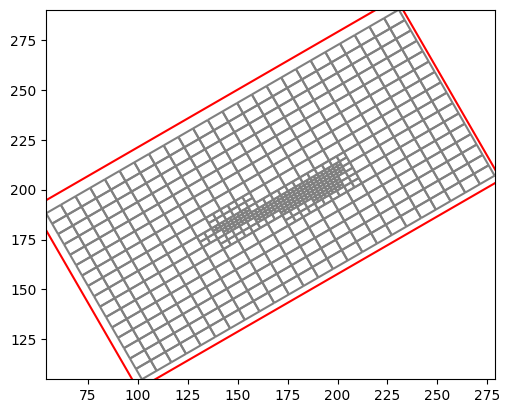

In [21]:
grid = ms.modelgrid
grid.plot()

# get bounding box archpy
points_box = T1.get_points_box()

# plot the bounding box
plt.plot(points_box[:, 0], points_box[:, 1], "r-")

# plt.ylim(0, 220)
# plt.xlim(-100, 220)

In [22]:
%matplotlib inline

In [23]:
import ArchPy.ap_mf
from ArchPy.ap_mf import archpy2modflow, array2cellids
from ArchPy.uppy import upscale_k, rotate_point

In [24]:
archpy_flow = archpy2modflow(T1, exe_name="../../../../exe/mf6.exe")  # create the modflow model
archpy_flow.create_sim(grid_mode="disv", iu=0, unit_limit=None,
                       factor_x=7, factor_y=7, factor_z=7,
                       modflowgrid_props=g.get_gridprops_disv(), xorigin=ox, yorigin=oy, angrot=rot_angle)  # create the simulation

Simulation created with the following parameters:
Grid mode: disv
To retrieve the simulation, use the get_sim() method


In [25]:
archpy_flow.set_k("K", iu=0, ifa=0, ip=0, log=True, upscaling_method="simplified_renormalization", average_facies =True)  # set the hydraulic conductivity

In [26]:
# archpy_flow.set_k("K", k = 1e-3)

In [27]:
sim = archpy_flow.get_sim()
gwf = archpy_flow.get_gwf()

In [28]:
grid = gwf.modelgrid

In [29]:
# select areas for BC

# %matplotlib tk
# grid.plot()
# p = plt.ginput(4)

In [30]:
plt.close()
%matplotlib inline  

In [31]:
p = np.array([(104.87903227621581, 198.4064505320487),
 (108.16935487760529, 108.74515964418504),
 (301.8870980344116, 197.17257955652764),
 (302.2983883595853, 107.92257899383765)])

In [32]:
from shapely.geometry import LineString

l1 = LineString([p[0], p[1]])
l2 = LineString([p[2], p[3]])

ix = fp.utils.gridintersect.GridIntersect(mfgrid=grid)

cid1 = ix.intersects(l1).cellids
cid2 = ix.intersects(l2).cellids
h1 = 0.3
h2 = 0

# create the bc (chd package on each layers)
chd_lst = []
for ilay in range(nlay):
    chd_lst += [((ilay, id1), h1) for id1 in cid1]
for ilay in range(nlay):
    chd_lst += [((ilay, id2), h2) for id2 in cid2]

chd = fp.mf6.ModflowGwfchd(gwf, stress_period_data=chd_lst, save_flows=True, pname="CHD")

In [33]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model test...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package chd...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 128 based on size of stress_period_data
FloPy is using the following executable to run the model: \\home\schorppl$\exe\mf6.exe


                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.1 02/10/2025

   MODFLOW 6 compiled Feb 14 2025 13:40:10 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthoriz

    Solving:  Stress period:     1    Time step:     1
 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2025/11/03 10:09:33
 Elapsed run time:  0.355 Seconds
 
 Normal termination of simulation.


(True, [])

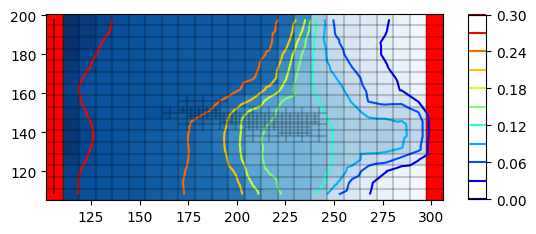

In [34]:
heads = archpy_flow.get_heads(kstpkper=(0, 0))
heads[heads == 1e30] = np.nan

cobj = gwf.output.budget()
qx, qy, qz = fp.utils.postprocessing.get_specific_discharge(
        cobj.get_data(text="DATA-SPDIS", kstpkper=(0, 0))[0], gwf)
import flopy
from flopy.plot import PlotMapView
mapview = PlotMapView(model=gwf, layer=2)
quadmesh = mapview.plot_array(heads, cmap="Blues")
quadmesh = mapview.contour_array(heads, cmap="jet", levels=10)
# quadmesh = mapview.plot_array(np.log10(gwf.npf.k.array), cmap="viridis")
# mapview.plot_vector(qx, qy, color="black", istep=3, jstep=3)
mapview.plot_bc("CHD", color="red")
mapview.plot_grid(alpha=.1, color="black")

# colorbar
plt.colorbar(quadmesh, shrink=0.5, aspect=10)

Let's do some particle tracking into this model

For convenience, the modelgrid is rotated in its original position. Note that this implies to set the rotation angle to 0. This is not intuitive but it's because the vertices of the grid already integrate the rotation. 
Warning, do not rotate the grid in the original modflow model, create a copy first.

In [35]:
import copy 

gwf_copy = copy.deepcopy(gwf)
grid = gwf_copy.modelgrid
grid.set_coord_info(angrot=0)

In [36]:
import ArchPy.ap_mf

Draw 100 particles in the model domain. 

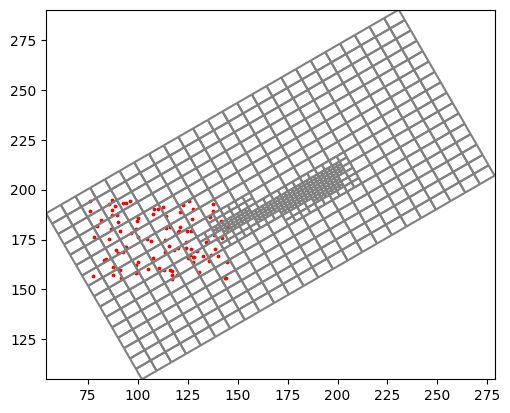

In [37]:
n = 100
xp = np.random.uniform(75, 145, n)
yp = np.random.uniform(155, 195, n)
zp = np.random.uniform(-6, -15, n)
list_p_coords = []
for i in range(n):
    list_p_coords.append((xp[i], yp[i], zp[i]))
plt.scatter(xp, yp, c="red", s=3)
grid.plot()

Create a prt model

In [38]:
archpy_flow.prt_create(prt_name="test_prt", workspace="ws_prt", trackdir="forward", list_p_coords=list_p_coords)
archpy_flow.set_porosity(prop_key="Porosity", iu=0, ifa=0, ip=0)
archpy_flow.prt_run(silent=False)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ems...
  writing model test_prt...
    writing model name file...
    writing package mip...
    writing package disv...
    writing package prp...
    writing package oc...
    writing package fmi...
FloPy is using the following executable to run the model: \\home\schorppl$\exe\mf6.exe


                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.1 02/10/2025

   MODFLOW 6 compiled Feb 14 2025 13:40:10 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthoriz

    Solving:  Stress period:     1    Time step:     1
 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2025/11/03 10:09:35
 Elapsed run time:  0.546 Seconds
 
 Normal termination of simulation.


Plot the pathlines on the grid

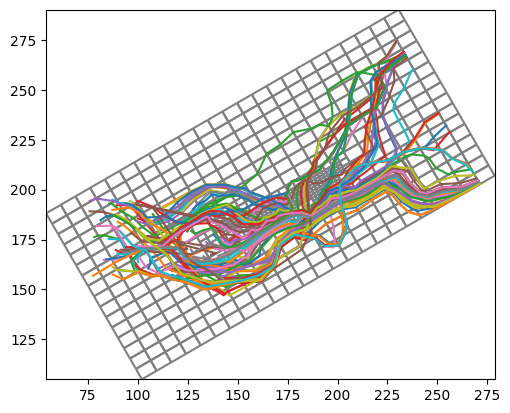

In [39]:
grid.plot()
for i in range(100):
    path = archpy_flow.prt_get_pathlines(i_particle=i+1)
    plt.plot(path["x"], path["y"])

We can also the check the facies along the pathlines.

In [40]:
df_p = archpy_flow.prt_get_facies_path_particle(3)

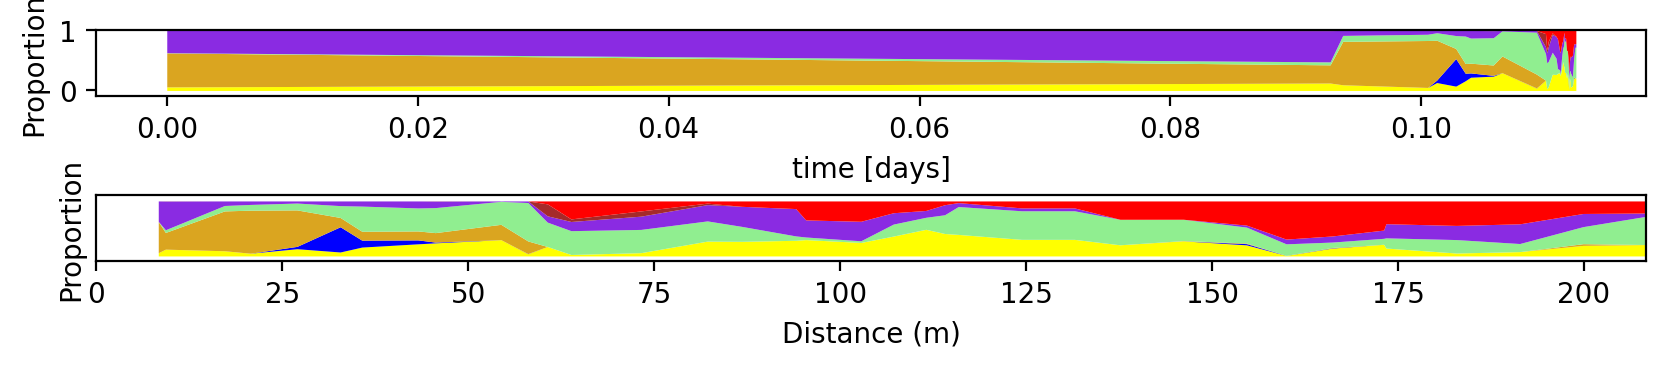

In [41]:
ArchPy.ap_mf.plot_particle_facies_sequence(T1, df=df_p, plot_distance=True, proportions=True, plot_time=True)

In [42]:
facies_smpl = []
facies = T1.get_facies()
for ix, iy in zip(*df_p[["x", "y"]].T.values):
    idx_y, idx_x = T1.coord2cell(x= ix, y=iy)
    facies_smpl.append(facies[0, 0, :, idx_y, idx_x])

In [43]:
arr_facies = np.array(facies_smpl).T

In [44]:
arr_plot = np.ones([*arr_facies.shape, 4])

for iv in np.unique(arr_facies):
    
    if iv != 0:
        arr_plot[arr_facies == iv, :] = matplotlib.colors.to_rgba(T1.get_facies_obj(ID = iv, type="ID").c)
    else:
        arr_plot[arr_facies == iv, :] = (1, 1, 1, 1)

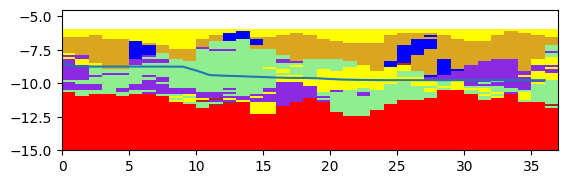

In [45]:
plt.imshow(arr_plot, origin="lower", interpolation="none", extent=[0, df_p.shape[0], T1.oz, T1.oz + T1.nz*T1.sz])
plt.plot(df_p["z"])

Plot to see the upscaled K field 

In [46]:
import ArchPy.ap_mf

In [47]:
k = gwf.npf.k.array  # get the hydraulic conductivity array
k22 = gwf.npf.k22.array  # get the hydraulic conductivity array
k33 = gwf.npf.k33.array  # get the vertical hydraulic conductivity array
Porosity = archpy_flow.upscale_prop("Porosity")

In [48]:
vert_exag = 3
vtk = Vtk(model=gwf, binary=False, vertical_exageration=vert_exag, smooth=True)
vtk.add_model(gwf)

vtk.add_array(np.log10(k), name="K")
vtk.add_array(np.log10(k33), name="K33")
vtk.add_array(np.log10(k22), name="K22")
vtk.add_array(Porosity, name="Porosity")
# vtk.add_array(archpy_flow.upscaled_facies[4], name="prop_fa1")
gwf_mesh = vtk.to_pyvista()

In [49]:
pv.set_jupyter_backend("client")

In [50]:
pl = pv.Plotter(notebook=True)
pl.add_mesh(gwf_mesh, opacity=1, show_edges=True, scalars="K", clim=[-10, -1])
pl.show()

Widget(value='<iframe src="http://localhost:50210/index.html?ui=P_0x21147461e50_5&reconnect=auto" class="pyvis…

In [51]:
pl = pv.Plotter(notebook=True)
pl.add_mesh(gwf_mesh, opacity=1, show_edges=True, scalars="K33", clim=[-10, -1])
pl.show()

Widget(value='<iframe src="http://localhost:50210/index.html?ui=P_0x211495a4cd0_6&reconnect=auto" class="pyvis…

In [52]:
T1.plot_prop("K", v_ex=3)

Widget(value='<iframe src="http://localhost:50210/index.html?ui=P_0x21147461f10_7&reconnect=auto" class="pyvis…

Plot of porosity

In [53]:
pl = pv.Plotter(notebook=True)
pl.add_mesh(gwf_mesh, opacity=1, show_edges=True, scalars="Porosity")
pl.show()

Widget(value='<iframe src="http://localhost:50210/index.html?ui=P_0x21144661b50_8&reconnect=auto" class="pyvis…

In [54]:
T1.plot_prop("Porosity", v_ex=3)

Widget(value='<iframe src="http://localhost:50210/index.html?ui=P_0x21149622e90_9&reconnect=auto" class="pyvis…

We can also investigate the anisotropic ratio (kx over kz)

In [55]:
vert_exag = 3
vtk = Vtk(model=gwf, binary=False, vertical_exageration=vert_exag, smooth=True)
vtk.add_model(gwf)

arr = np.log10(k / k33)
# arr = gwf.dis.idomain.array
vtk.add_array(arr, name="Kxx/Kzz")
gwf_mesh = vtk.to_pyvista()


In [56]:
pl = pv.Plotter(notebook=True)
pl.add_mesh(gwf_mesh, opacity=1, show_edges=True, scalars="Kxx/Kzz", clim=[0, 4])
pl.show()

Widget(value='<iframe src="http://localhost:50210/index.html?ui=P_0x21144a95f90_10&reconnect=auto" class="pyvi…

We can see that in many cells, the anisotropy ratio is exceeding 1000 --> refleting the heterogeneity of the model

Heads

In [57]:
vert_exag = 3

vtk = Vtk(model=gwf, binary=False, vertical_exageration=vert_exag, smooth=True)
vtk.add_model(gwf)

arr = archpy_flow.get_heads(kstpkper=(0, 0))
# arr = gwf.dis.idomain.array
vtk.add_array(arr, name="Heads")
gwf_mesh = vtk.to_pyvista()
pl = pv.Plotter(notebook=True)
pl.add_mesh(gwf_mesh, opacity=1, show_edges=True, scalars="Heads")
pl.show()

Widget(value='<iframe src="http://localhost:50210/index.html?ui=P_0x2114a751d90_11&reconnect=auto" class="pyvi…